In [32]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

# -------------------------
# DEVICE
# -------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# MODEL ARCHITECTURE
# -------------------------
class CNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [33]:
MODEL_PATH = "cnn_pipeline_model.pth"  # your trained weights

checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)

model = CNNModel(num_classes=2).to(DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("✅ Model loaded successfully")


✅ Model loaded successfully


In [34]:
IMG_SIZE = (224, 224)

preprocessing_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()   # NO normalization (same as training)
])


In [35]:
def predict_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = preprocessing_transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(img_tensor)           # shape: [1, 2]
        probs = torch.softmax(outputs, dim=1)
        pred_class = probs.argmax(dim=1).item()
        confidence = probs[0, pred_class].item()

    label_map = {
        1: "Non-defective",
        0: "Defective"
    }

    return label_map[pred_class], confidence


In [52]:
image_path = r"C:\Users\maila\Desktop\Defect_Detection\Renamed_Not_OK\3000.jpg"   # change this

label, conf = predict_image(image_path)

print(f"Prediction : {label}")
print(f"Confidence : {conf:.2%}")


Prediction : Defective
Confidence : 99.97%


In [59]:
from tqdm import tqdm
import os

IMAGE_FOLDER = r"C:\Users\maila\Desktop\Defect_Detection\Renamed_Not_OK"

# -------------------------
# COUNTERS
# -------------------------
total_images = 0
defective_count = 0
non_defective_count = 0

valid_exts = (".jpg", ".jpeg", ".png")

# -------------------------
# INFERENCE LOOP
# -------------------------
for img_name in tqdm(os.listdir(IMAGE_FOLDER), desc="Running inference"):
    if not img_name.lower().endswith(valid_exts):
        continue

    img_path = os.path.join(IMAGE_FOLDER, img_name)

    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Skipping {img_name}: {e}")
        continue

    img_tensor = preprocessing_transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(img_tensor)
        pred_class = outputs.argmax(dim=1).item()

    total_images += 1

    if pred_class == 0:
        defective_count += 1
    else:
        non_defective_count += 1


# -------------------------
# FINAL SUMMARY
# -------------------------
print("\n" + "=" * 50)
print("📊 FOLDER PREDICTION SUMMARY")
print("=" * 50)
print(f"Total images        : {total_images}")
print(f"Predicted Defective : {defective_count}")
print(f"Predicted Non-Defective : {non_defective_count}")
print("=" * 50)

Running inference: 100%|██████████| 4699/4699 [01:16<00:00, 61.64it/s]


📊 FOLDER PREDICTION SUMMARY
Total images        : 4699
Predicted Defective : 4677
Predicted Non-Defective : 22


In [58]:
from tqdm import tqdm
import os

IMAGE_FOLDER = r"C:\Users\maila\Desktop\Defect_Detection\Renamed_Ok"

# -------------------------
# COUNTERS
# -------------------------
total_images = 0
defective_count = 0
non_defective_count = 0

valid_exts = (".jpg", ".jpeg", ".png")

# -------------------------
# INFERENCE LOOP
# -------------------------
for img_name in tqdm(os.listdir(IMAGE_FOLDER), desc="Running inference"):
    if not img_name.lower().endswith(valid_exts):
        continue

    img_path = os.path.join(IMAGE_FOLDER, img_name)

    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Skipping {img_name}: {e}")
        continue

    img_tensor = preprocessing_transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(img_tensor)
        pred_class = outputs.argmax(dim=1).item()

    total_images += 1

    if pred_class == 0:
        defective_count += 1
    else:
        non_defective_count += 1


# -------------------------
# FINAL SUMMARY
# -------------------------
print("\n" + "=" * 50)
print("📊 FOLDER PREDICTION SUMMARY")
print("=" * 50)
print(f"Total images        : {total_images}")
print(f"Predicted Defective : {defective_count}")
print(f"Predicted Non-Defective : {non_defective_count}")
print("=" * 50)

Running inference: 100%|██████████| 1002/1002 [00:16<00:00, 59.93it/s]


📊 FOLDER PREDICTION SUMMARY
Total images        : 1002
Predicted Defective : 398
Predicted Non-Defective : 604


MODEL EVALUATION METRICS
Accuracy              : 92.63%
Precision (Defective) : 92.16%
Recall / Sensitivity  : 99.53%
F1-Score              : 95.70%
Specificity           : 60.28%
False Positive Rate   : 39.72%
False Negative Rate   : 0.47%
Negative Predictive Value : 96.49%
Balanced Accuracy     : 79.91%


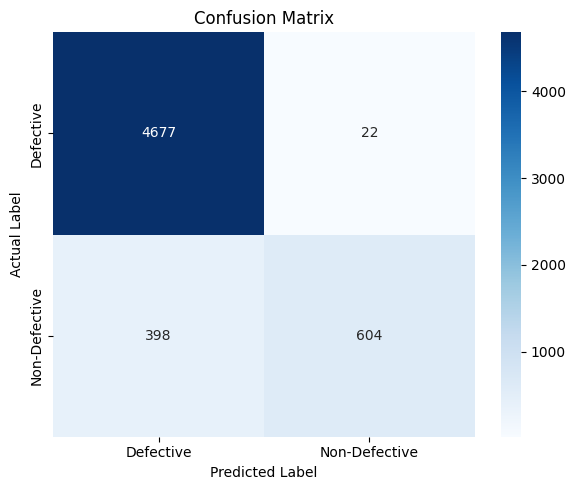

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================
# CONFUSION MATRIX VALUES (from your experiment)
# ======================================================
TP = 4677  # Defective correctly predicted
FN = 22    # Defective predicted as Non-defective
FP = 398   # Non-defective predicted as Defective
TN = 604   # Non-defective correctly predicted

# Confusion matrix
cm = np.array([[TP, FN],
               [FP, TN]])

# ======================================================
# METRIC CALCULATIONS
# ======================================================
accuracy = (TP + TN) / (TP + TN + FP + FN)

precision = TP / (TP + FP)
recall = TP / (TP + FN)                 # Sensitivity
f1_score = 2 * precision * recall / (precision + recall)

specificity = TN / (TN + FP)
fpr = FP / (FP + TN)
fnr = FN / (FN + TP)
npv = TN / (TN + FN)

balanced_accuracy = (recall + specificity) / 2

# ======================================================
# PRINT METRICS
# ======================================================

print("MODEL EVALUATION METRICS")

print(f"Accuracy              : {accuracy*100:.2f}%")
print(f"Precision (Defective) : {precision*100:.2f}%")
print(f"Recall / Sensitivity  : {recall*100:.2f}%")
print(f"F1-Score              : {f1_score*100:.2f}%")
print(f"Specificity           : {specificity*100:.2f}%")
print(f"False Positive Rate   : {fpr*100:.2f}%")
print(f"False Negative Rate   : {fnr*100:.2f}%")
print(f"Negative Predictive Value : {npv*100:.2f}%")
print(f"Balanced Accuracy     : {balanced_accuracy*100:.2f}%")


# ======================================================
# PLOT CONFUSION MATRIX
# ======================================================
labels = ["Defective", "Non-Defective"]

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
